# Bayesian Plotting

3ML's Bayesian capabilites include the ability to examine marginal distributions and compare model parameters between fits. 

This tutorial demonstrates some of these capabilities. 

Simple corner plots require the corner package. 

ChainConsumer is required for more advanced plots. https://github.com/Samreay/ChainConsumer



In [2]:
%matplotlib inline
%matplotlib notebook

from threeML import *


## Data setup and sampling


We will use Fermi GBM data for this example. The following code sets up the data and Bayesian fits. 

We use emcee to sample, but any of the included samplers will work.


In [16]:
data_dir = os.path.join('gbm','bn080916009')

src_selection = "0.-72."


nai3 = FermiGBMLikeTTE('NAI3',
                         os.path.join(data_dir, "glg_tte_n3_bn080916009_v01.fit.gz"),
                         "-10-0, 100-200",
                         src_selection,
                         rsp_file=os.path.join(data_dir, "glg_cspec_n3_bn080916009_v07.rsp"))

bgo0 = FermiGBMLikeTTE('BGO0',
                         os.path.join(data_dir, "glg_tte_b0_bn080916009_v01.fit.gz"),
                         "-10-0,100-200",
                         src_selection,
                         rsp_file=os.path.join(data_dir, "glg_cspec_b0_bn080916009_v07.rsp"))


nai3.set_active_measurements("10.0-30.0", "40.0-900.0")

bgo0.set_active_measurements("250-43000")



triggerName = 'bn080916009'
ra = 121.8
dec = -61.3


data_list = DataList(nai3,bgo0 )

band = Band()


GRB = PointSource( triggerName, ra, dec, spectral_shape=band )

model = Model( GRB )


band.K.prior = Log_uniform_prior(lower_bound=1e-4, upper_bound=3)
band.xp.prior = Log_uniform_prior(lower_bound=10, upper_bound=1e5)

# or use the set_uninformative_prior method, which will use as lower_bound
# and upper_bound the current boundaries for the parameter. Such boundaries
# must exists and be finite

band.alpha.set_uninformative_prior(Uniform_prior)
band.beta.set_uninformative_prior(Uniform_prior)

bayes = BayesianAnalysis(model, data_list)

samples = bayes.sample(n_walkers=50,burn_in=500, n_samples=1000)

Auto-determined polynomial order: 1


Auto-probed noise models:
- observation: poisson
- background: gaussian
Auto-determined polynomial order: 1


Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 10.0-30.0 translates to channels 6-21
Range 40.0-900.0 translates to channels 27-124
Now using 114 channels out of 128
Range 250-43000 translates to channels 1-126
Now using 126 channels out of 128
Running burn-in of 500 samples...


Sampling...


Mean acceptance fraction: 0.5425


### Simple corner plot

We can look at the marginal distributions for the parameters with corner.





<IPython.core.display.Javascript object>


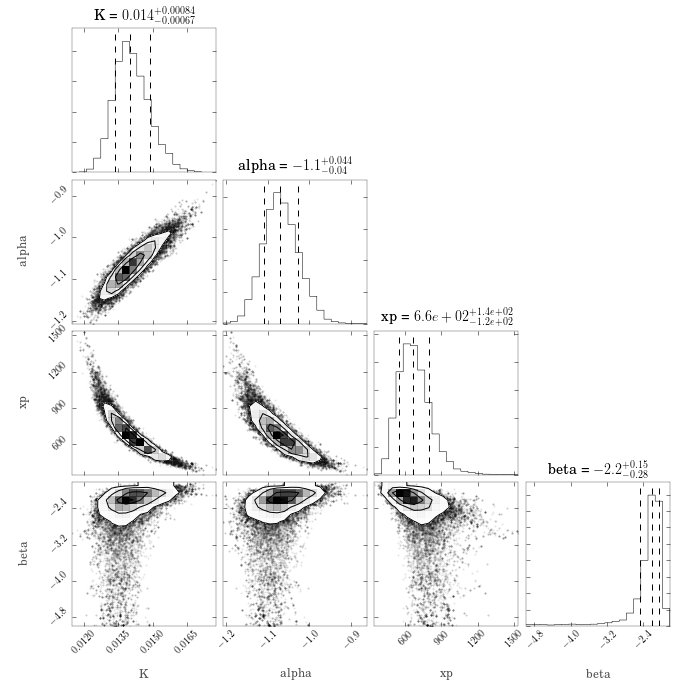

In [17]:
_=bayes.corner_plot()

### Advanced corner plot

Using chain consumer, we can have more options for our plots.

Here is the default plot



<IPython.core.display.Javascript object>


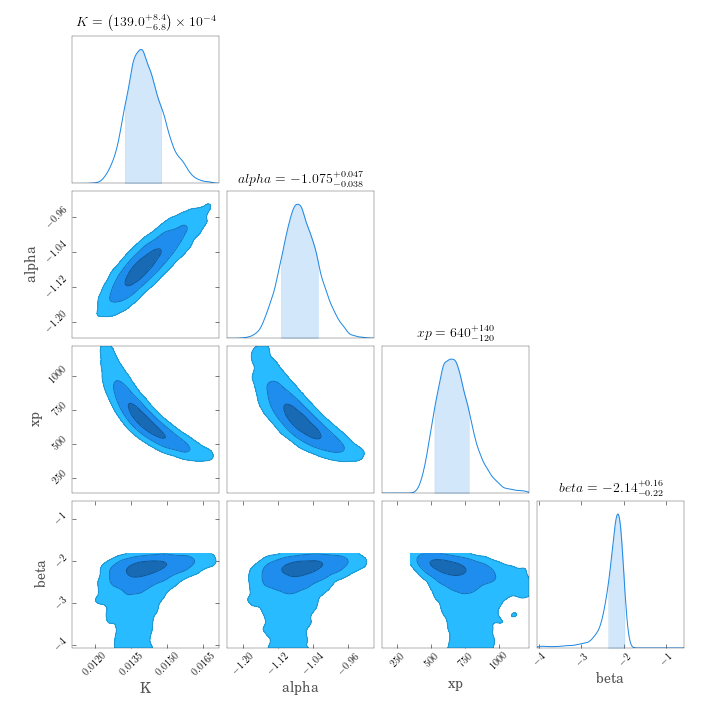

In [18]:
_=bayes.corner_plot_cc()

We can look at the cloud  or sampled points. Additionally, we can change the sigma level of the contours. Colors must be provided as HTML codes to facilitate the contour levels.

<IPython.core.display.Javascript object>


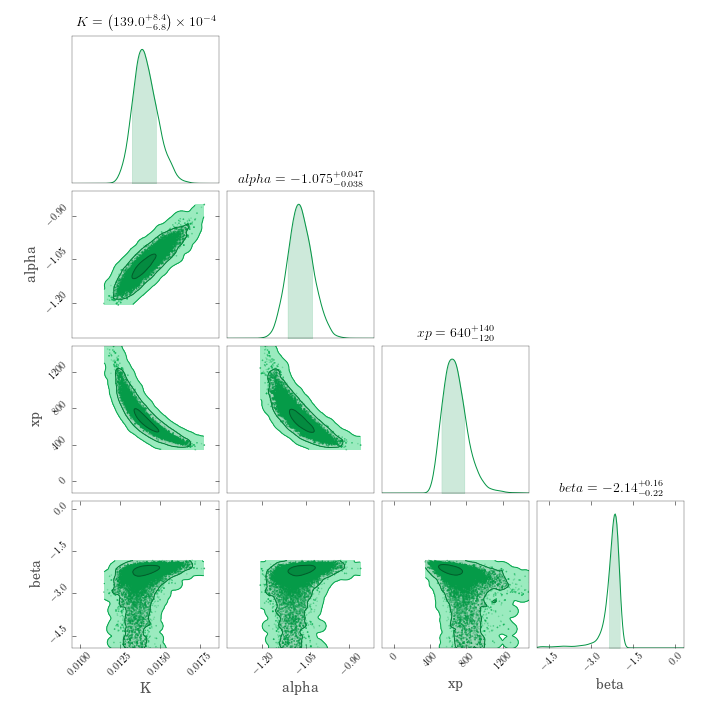

In [25]:
_=bayes.corner_plot_cc(sigmas=[0,1,3,5],cloud=True,shade_alpha=.4,colours="#059546")

It is also possible to change parameter names. A dictionary of {old:new} names can be provided. 

<IPython.core.display.Javascript object>


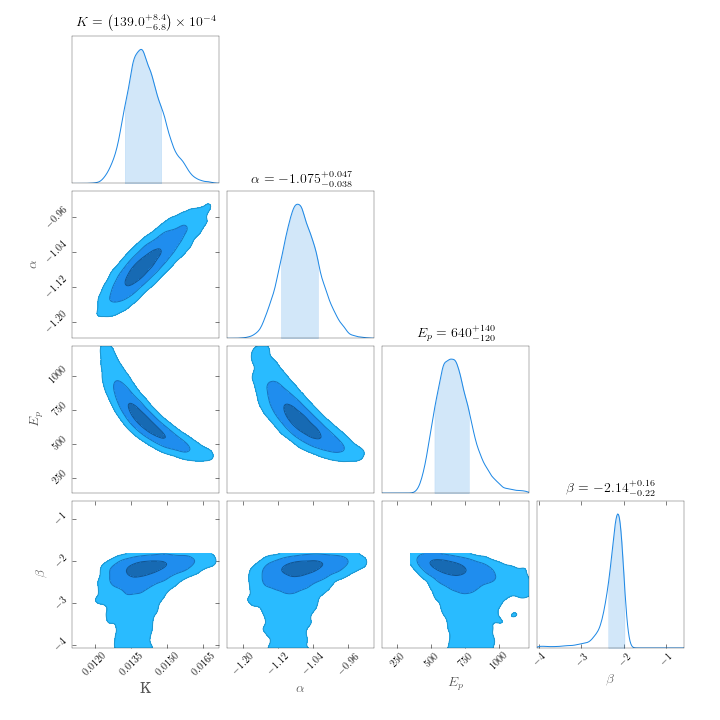

In [26]:
renamed ={'xp':'$E_p$',
          'alpha':'$\\alpha$',
          'beta':'$\\beta$'}

_=bayes.corner_plot_cc(renamed_parameters=renamed)

### Comparing distributions

Perhaps we want to look at two fits that are related. Here we use the example of Band+ Blackbody and will examine how the band parameters change when we included the extra component.



In [21]:
bandbb = Band() + Blackbody()


GRB2 = PointSource( triggerName, ra, dec, spectral_shape=bandbb )

model2 = Model( GRB2 )


bandbb.K_1.prior = Log_uniform_prior(lower_bound=1e-4, upper_bound=3)
bandbb.xp_1.prior = Log_uniform_prior(lower_bound=10, upper_bound=1e5)


bandbb.alpha_1.set_uninformative_prior(Uniform_prior)
bandbb.beta_1.set_uninformative_prior(Uniform_prior)

bandbb.K_2.prior = Log_uniform_prior(lower_bound=1e-4, upper_bound=3)
bandbb.kT_2.prior = Log_uniform_prior(lower_bound=1E1, upper_bound=500)

bayes2 = BayesianAnalysis(model2, data_list)

samples2 = bayes2.sample(n_walkers=50,burn_in=500, n_samples=1000)

Running burn-in of 500 samples...


Sampling...


Mean acceptance fraction: 0.40156


We can examine the marginals of all parameters first

<IPython.core.display.Javascript object>


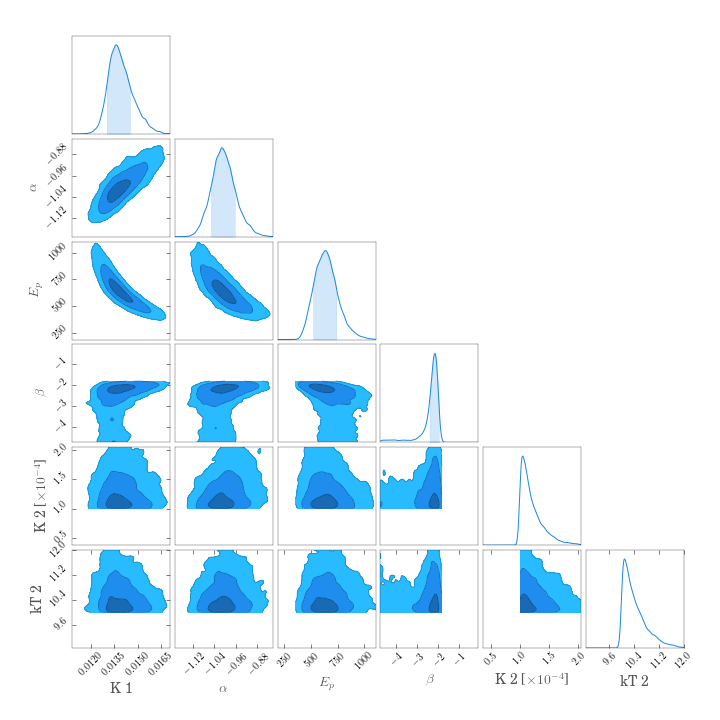

In [29]:
renamed ={'xp_1':'$E_p$',
          'alpha_1':'$\\alpha$',
          'beta_1':'$\\beta$'}

_ = bayes2.corner_plot_cc(renamed_parameters=renamed)

#### Comparing parameters

Now let's compare to the original Band fit. We will have to do some manipulation because composite models from astromodels append numbers to clearly identify components.

We need to rename parameters so that those we wish to compare have the same names:




<IPython.core.display.Javascript object>


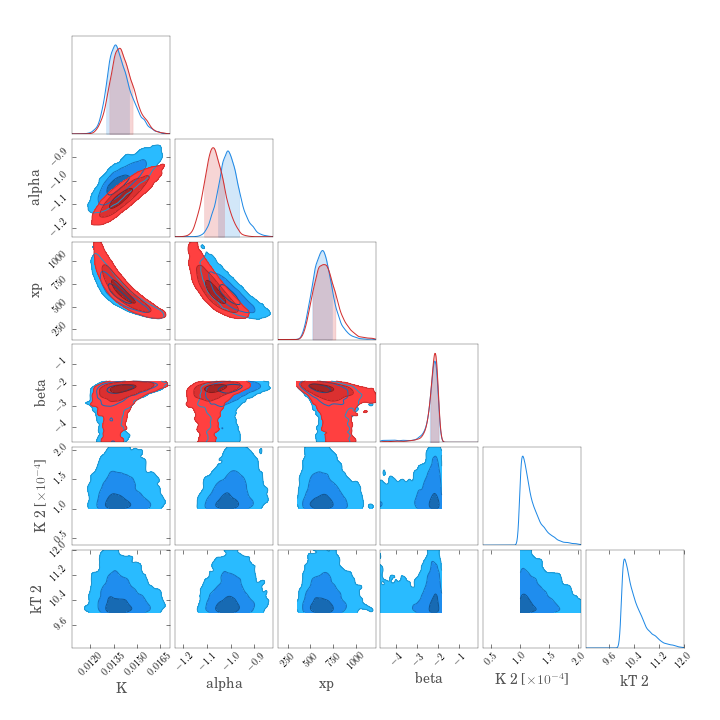

In [30]:
renamed ={'xp_1':'xp',
          'alpha_1':'alpha',
          'beta_1':'beta',
          'K_1':'K'}

_ = bayes2.compare_posterior(bayes,renamed_parameters=renamed)

We can see that there is a shift in some parameters of the Band function due to the additional components.

Perhaps we want to focus on a subset of the parameters to draw more attenttioon to them. This is easily accomplished by passing the parameters we are interested in. **NOTE:** We must use the original parameter names so that they are picked up!

<IPython.core.display.Javascript object>


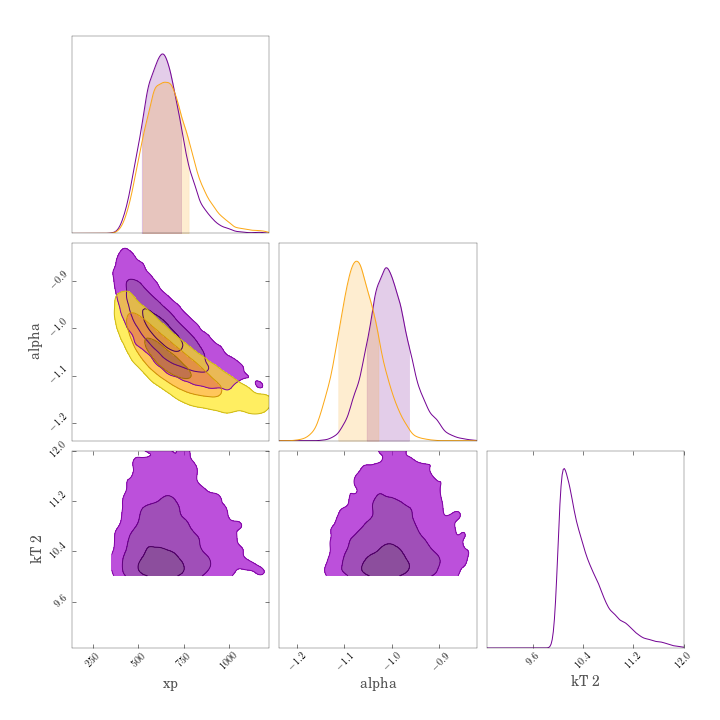

In [33]:
_=bayes2.compare_posterior(bayes,renamed_parameters=renamed,shade_alpha=.7,parameters=['xp','alpha','kT 2'],colours=["#740595","#FCA816"])